Conversion reaction
===================

In [1]:
import importlib
import os
import sys
import numpy as np
import amici
import amici.plotting
import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize

# sbml file we want to import
sbml_file = 'conversion_reaction/model_conversion_reaction.xml'
# name of the model that will also be the name of the python module
model_name = 'model_conversion_reaction'
# directory to which the generated model code is written
model_output_dir = 'tmp/' + model_name

## Compile AMICI model

In [2]:
# import sbml model, compile and generate amici module
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         verbose=False)

## Load AMICI model

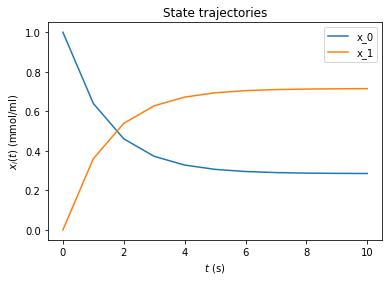

In [3]:
# load amici module (the usual starting point later for the analysis)
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)
model = model_module.getModel()
model.requireSensitivitiesForAllParameters()
model.setTimepoints(np.linspace(0, 10, 11))
model.setParameterScale(amici.ParameterScaling.log10)
model.setParameters([-0.3,-0.7])
solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)
edata = amici.ExpData(rdata, 0.2, 0.0)

## Optimize

In [4]:
# create objective function from amici model
# pesto.AmiciObjective is derived from pesto.Objective, 
# the general pesto objective function class
objective = pypesto.AmiciObjective(model, solver, [edata], 1)

# create optimizer object which contains all information for doing the optimization
optimizer = optimize.ScipyOptimizer(method='ls_trf')

# create problem object containing all information on the problem to be solved
problem = pypesto.Problem(objective=objective, 
                          lb=[-2,-2], ub=[2,2])

# do the optimization
result = optimize.minimize(problem=problem, 
                           optimizer=optimizer, 
                           n_starts=10)

Parameters obtained from history and optimizer do not match: [-0.29388398 -0.88350411], [-0.29390298 -0.88353858]


## Visualize

<AxesSubplot:xlabel='fval', ylabel='gradient norm'>

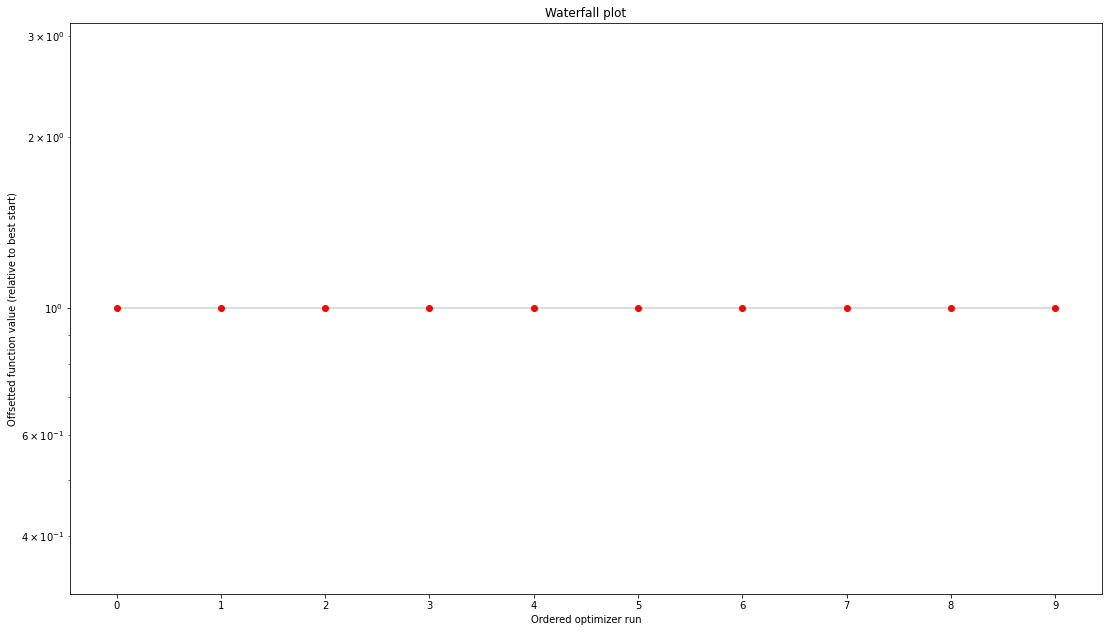

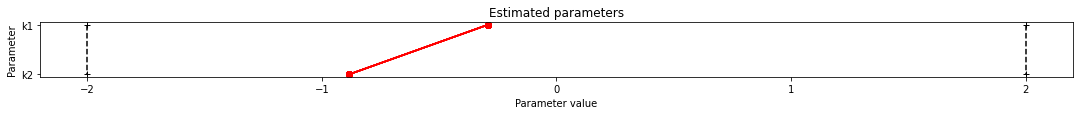

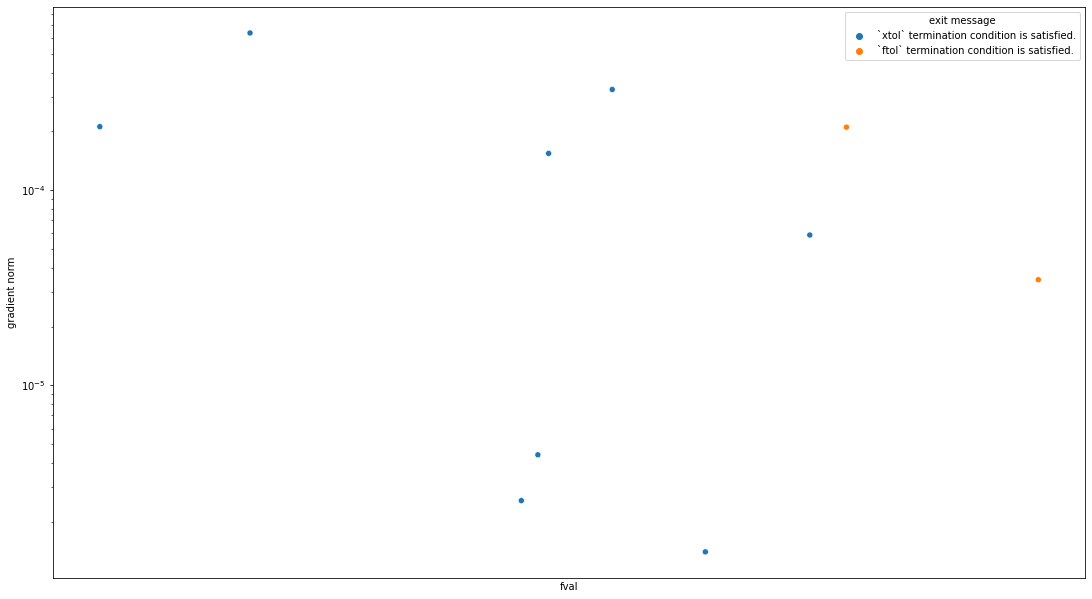

In [5]:
visualize.waterfall(result)
visualize.parameters(result)
visualize.optimizer_convergence(result)

## Profiles

In [6]:
import pypesto.profile as profile

profile_options = profile.ProfileOptions(min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01)

result = profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options)

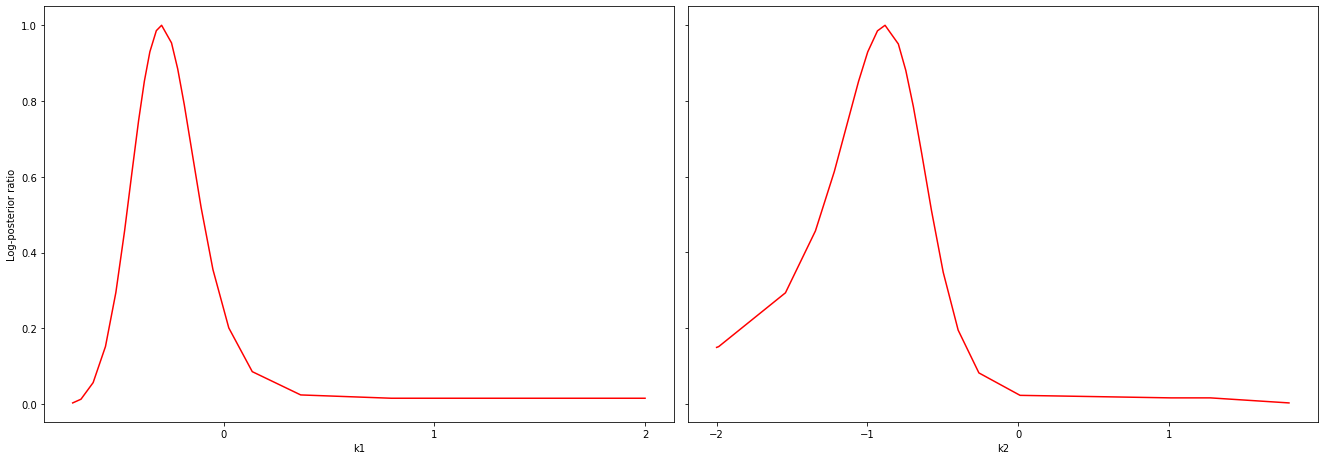

In [7]:
# specify the parameters, for which profiles should be computed
ax = visualize.profiles(result)

## Sampling

In [8]:
import pypesto.sample as sample

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    n_chains=3)

result = sample.sample(problem, n_samples=10000, sampler=sampler, result=result)

100%|██████████| 10000/10000 [00:43<00:00, 229.65it/s]


Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., 'pypesto.sample.geweke_test'.


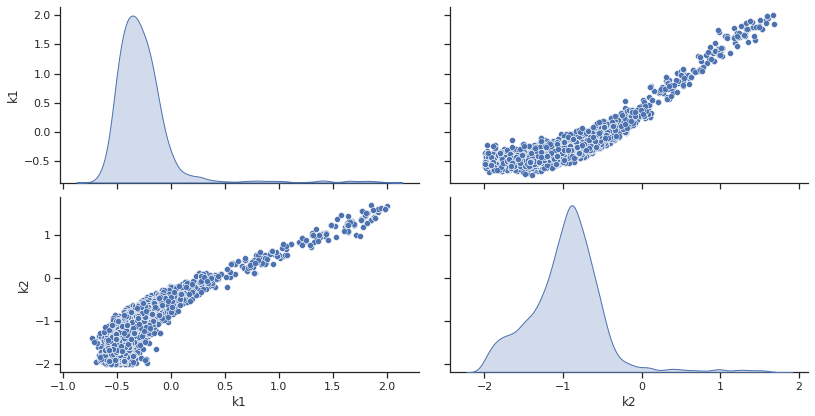

In [9]:
ax = visualize.sampling_scatter(result, size=[13,6])

## Predict

In [10]:
# Let's create a function, which predicts the ratio of x_1 and x_0
import pypesto.prediction as prediction

def ratio_function(amici_output_list):
    # This (optional) function post-processes the results from AMICI and must accept one input:
    # a list of dicts, with the fields t, x, y[, sx, sy - if sensi_orders includes 1]
    # We need to specify the simulation condition: here, we only have one, i.e., it's [0]
    x = amici_output_list[0]['x']
    ratio = x[:,1] / x[:,0]
    # we need to output also at least one simulation condition
    return [ratio]
    
# create pypesto prediction function
predictor = prediction.AmiciPredictor(objective, post_processor=ratio_function, observable_ids=['ratio'])

# run prediction
predicted = predictor(x=model.getUnscaledParameters())

In [11]:
dict(predicted)

{'conditions': [{'timepoints': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
   'observable_ids': ['ratio'],
   'x_names': ['k1', 'k2'],
   'output': array([0.        , 1.95196396, 2.00246152, 2.00290412, 2.00290796,
          2.00290801, 2.00290801, 2.00290799, 2.002908  , 2.00290801,
          2.002908  ]),
   'output_sensi': None}],
 'condition_ids': ['condition_0'],
 'comment': None,
 'parameter_ids': ['k1', 'k2']}

## Analyze parameter sets

In [12]:
# We want to use the sample result to create a prediction
from pypesto.collections import collections

# first collect some vectors from the sampling result
vectors = result.sample_result.trace_x[0, ::20, :]

# create the collection
collection = collections.Collection(vectors, 
                                    x_names=problem.x_names, 
                                    coll_type=collections.CollectionType.sample,
                                    lower_bound=problem.lb,
                                    upper_bound=problem.ub)

# we can also perform an approximative identifiability analysis
summary = collection.compute_summary()
identifiability = collection.check_identifiability()
print(identifiability.transpose())

parameterId              k1        k2
parameterId              k1        k2
lowerBound               -2        -2
upperBound                2         2
collection_mean   -0.588711 -0.631594
collection_std     0.294814  0.271979
collection_median -0.588711 -0.631594
within lb: 1 std       True      True
within ub: 1 std       True      True
within lb: 2 std       True      True
within ub: 2 std       True      True
within lb: 3 std       True      True
within ub: 3 std       True      True


In [13]:
# run a prediction
collection_prediction = collection.predict(predictor, prediction_id='ratio_over_time')

# go for some analysis
prediction_summary = collection_prediction.compute_summary(percentiles_list=(1, 5, 10, 25, 75, 90, 95, 99))
dict(prediction_summary)

{'mean': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b81bcd0>,
 'std': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b8c3640>,
 'median': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b8c37c0>,
 'percentile 1': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b791070>,
 'percentile 5': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b791430>,
 'percentile 10': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b7917f0>,
 'percentile 25': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b791250>,
 'percentile 75': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b8bd970>,
 'percentile 90': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b8bd670>,
 'percentile 95': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b8bdbb0>,
 'percentile 99': <pypesto.prediction.prediction.PredictionResult at 0x7fec1b8bd910>}